In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Tue Jan 16 18:34:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'uniform', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


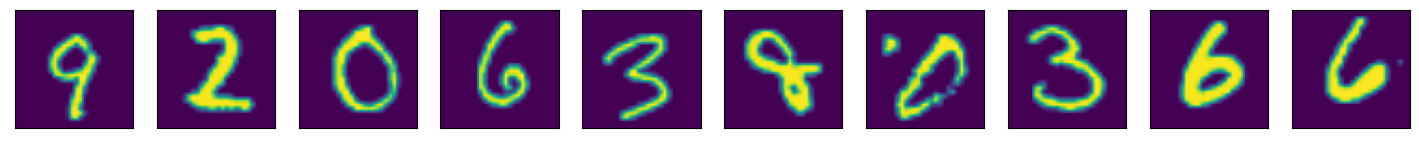

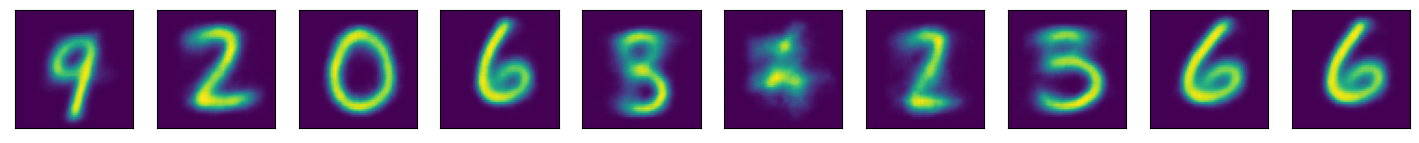

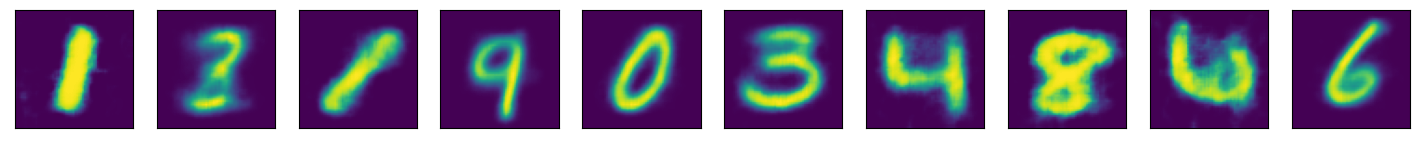

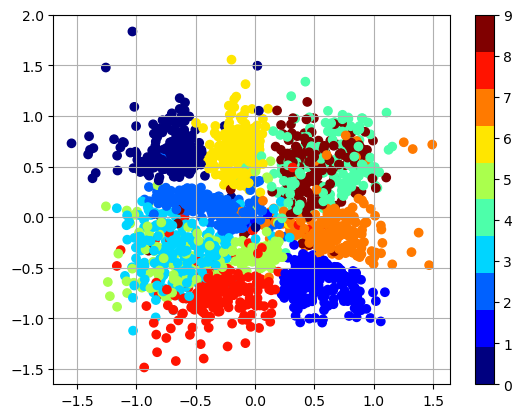

9001
mmd_loss -0.004235541820526123
recon_loss 0.11512234807014465
9002
mmd_loss -0.00010432898998260498
recon_loss 0.11573140025138855
9003
mmd_loss -0.00685669481754303
recon_loss 0.1104538843035698
9004
mmd_loss -0.0032115668058395387
recon_loss 0.11303294971585273
9005
mmd_loss -0.0019318342208862304
recon_loss 0.11166151016950607
9006
mmd_loss -0.002125099301338196
recon_loss 0.11664899215102195
9007
mmd_loss -0.0006451219320297241
recon_loss 0.10816222503781318
9008
mmd_loss -0.0032362937927246094
recon_loss 0.11117698028683662
9009
mmd_loss -0.0035967200994491575
recon_loss 0.11938526704907418
9010
mmd_loss -0.0025511592626571654
recon_loss 0.10980802923440933
9011
mmd_loss -0.0014131814241409302
recon_loss 0.11765033826231956
9012
mmd_loss -0.0007923126220703125
recon_loss 0.11741537675261497
9013
mmd_loss -0.008578529953956604
recon_loss 0.11060004830360412
9014
mmd_loss -0.0001946777105331421
recon_loss 0.11241274774074554
9015
mmd_loss -0.003823152184486389
recon_loss 0.1083

mmd_loss -0.00031709372997283934
recon_loss 0.11037827208638192
9124
mmd_loss -0.006832107901573181
recon_loss 0.1112618736922741
9125
mmd_loss -0.006954050064086914
recon_loss 0.11694122478365898
9126
mmd_loss -0.0016336351633071899
recon_loss 0.11370838657021523
9127
mmd_loss -0.0021720707416534426
recon_loss 0.1136536605656147
9128
mmd_loss -0.0025223374366760256
recon_loss 0.11174432262778282
9129
mmd_loss -0.000267067551612854
recon_loss 0.10683493316173553
9130
mmd_loss -0.004631322622299194
recon_loss 0.11525050103664398
9131
mmd_loss -0.00704943835735321
recon_loss 0.11269362196326256
9132
mmd_loss 0.0047439754009246824
recon_loss 0.11187672764062881
9133
mmd_loss -0.006223601102828979
recon_loss 0.11504451632499695
9134
mmd_loss -0.0023749828338623046
recon_loss 0.11621641218662263
9135
mmd_loss -0.004092764854431152
recon_loss 0.11529512032866478
9136
mmd_loss 0.003408154845237732
recon_loss 0.11389404162764549
9137
mmd_loss 0.005026686191558838
recon_loss 0.11747390627861024

mmd_loss -0.004554387927055359
recon_loss 0.11759759932756424
9247
mmd_loss -0.00532476007938385
recon_loss 0.11790776029229164
9248
mmd_loss -0.002084982395172119
recon_loss 0.11592579558491707
9249
mmd_loss -0.004507949948310852
recon_loss 0.11257103979587554
9250
mmd_loss -0.0003488451242446899
recon_loss 0.11620306596159935
9251
mmd_loss 0.001160883903503418
recon_loss 0.11071200668811798
9252
mmd_loss 0.0027748793363571167
recon_loss 0.1152405358850956
9253
mmd_loss -0.004520189762115478
recon_loss 0.11573603078722954
9254
mmd_loss -0.0022829800844192507
recon_loss 0.11522420942783355
9255
mmd_loss -0.0003085970878601074
recon_loss 0.11513873264193535
9256
mmd_loss -0.0012196183204650878
recon_loss 0.11235128864645957
9257
mmd_loss -0.0048384606838226315
recon_loss 0.10927324816584587
9258
mmd_loss -0.006382215023040772
recon_loss 0.11718090102076531
9259
mmd_loss 0.000947830080986023
recon_loss 0.11223798468708993
9260
mmd_loss -0.005204713344573975
recon_loss 0.11310338899493218

mmd_loss -0.004638293385505676
recon_loss 0.10987492501735688
9370
mmd_loss 0.0017965972423553468
recon_loss 0.11096420660614967
9371
mmd_loss -4.630982875823975e-05
recon_loss 0.11300949305295944
9372
mmd_loss -0.001349213719367981
recon_loss 0.1132564052939415
9373
mmd_loss -0.0040520399808883665
recon_loss 0.11859101280570031
9374
mmd_loss -0.002073577046394348
recon_loss 0.1064661368727684
9375
mmd_loss 0.0009456127882003784
recon_loss 0.112677913159132
9376
mmd_loss -0.004918631911277771
recon_loss 0.10788401067256928
9377
mmd_loss -0.0058250963687896725
recon_loss 0.11358099430799484
9378
mmd_loss 0.0007620394229888916
recon_loss 0.1161625474691391
9379
mmd_loss -0.00493265688419342
recon_loss 0.1089470162987709
9380
mmd_loss -0.0021653860807418824
recon_loss 0.11084018349647522
9381
mmd_loss -0.005815479159355164
recon_loss 0.10946821048855782
9382
mmd_loss 0.001407673954963684
recon_loss 0.11768044009804726
9383
mmd_loss -0.004242223501205444
recon_loss 0.10992416813969612
9384

mmd_loss -0.005736705660820007
recon_loss 0.11520204171538354
9493
mmd_loss -0.006463837623596191
recon_loss 0.11138238087296486
9494
mmd_loss -0.004809719324111938
recon_loss 0.11865925788879395
9495
mmd_loss -0.002926963567733765
recon_loss 0.11177831664681434
9496
mmd_loss -0.0028291106224060058
recon_loss 0.1150321014225483
9497
mmd_loss -0.0033771812915802
recon_loss 0.1206459254026413
9498
mmd_loss -0.003434985876083374
recon_loss 0.10649353936314583
9499
mmd_loss -0.002383488416671753
recon_loss 0.11895281001925469
9500
mmd_loss -0.003929942846298218
recon_loss 0.1170003242790699
9501
mmd_loss -2.319812774658203e-05
recon_loss 0.11429741531610489
9502
mmd_loss -0.0021691501140594484
recon_loss 0.12086649462580681
9503
mmd_loss -0.004947212338447571
recon_loss 0.11161736696958542
9504
mmd_loss -0.006986549496650696
recon_loss 0.11059460639953614
9505
mmd_loss 9.630918502807617e-05
recon_loss 0.11636165231466293
9506
mmd_loss -0.0027200669050216676
recon_loss 0.114178516715765
950

mmd_loss 0.0015215158462524414
recon_loss 0.10990350991487503
9616
mmd_loss -0.0026209115982055663
recon_loss 0.11039650216698646
9617
mmd_loss -0.005685114860534668
recon_loss 0.11264417544007302
9618
mmd_loss -0.005743694305419922
recon_loss 0.1125759594142437
9619
mmd_loss -0.0012019753456115722
recon_loss 0.11242204681038856
9620
mmd_loss -0.0013178706169128418
recon_loss 0.11137520223855972
9621
mmd_loss -0.007445904612541199
recon_loss 0.11367235407233238
9622
mmd_loss 0.0011745870113372802
recon_loss 0.1238144502043724
9623
mmd_loss -0.004238587617874145
recon_loss 0.11863893792033195
9624
mmd_loss -0.007427084445953369
recon_loss 0.11248994022607803
9625
mmd_loss -0.004163911938667298
recon_loss 0.1132595494389534
9626
mmd_loss 0.005343478918075561
recon_loss 0.11262694597244263
9627
mmd_loss -0.003208792209625244
recon_loss 0.11563931703567505
9628
mmd_loss -0.003315812349319458
recon_loss 0.1135187029838562
9629
mmd_loss -0.0022774994373321532
recon_loss 0.11399445235729218
9

mmd_loss 0.0029019445180892946
recon_loss 0.11666827574372292
9739
mmd_loss 0.006544825434684753
recon_loss 0.11809172332286835
9740
mmd_loss 0.004393044114112854
recon_loss 0.11685207486152649
9741
mmd_loss -0.006439322233200073
recon_loss 0.10837741419672967
9742
mmd_loss -0.0011096835136413575
recon_loss 0.11404152438044549
9743
mmd_loss -0.00465998649597168
recon_loss 0.1131709985435009
9744
mmd_loss -0.0019735634326934815
recon_loss 0.11733057424426079
9745
mmd_loss 0.001266452670097351
recon_loss 0.1149570181965828
9746
mmd_loss -0.003202971816062927
recon_loss 0.11079954504966735
9747
mmd_loss -0.00630151629447937
recon_loss 0.10932835787534714
9748
mmd_loss -0.007616153359413147
recon_loss 0.11511349380016327
9749
mmd_loss -0.0046998649835586544
recon_loss 0.11712234765291214
9750
mmd_loss -0.0008967548608779907
recon_loss 0.11762074455618858
9751
mmd_loss -0.0042445331811904905
recon_loss 0.11568557769060135
9752
mmd_loss -0.004482829570770263
recon_loss 0.10893214493989944
97

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        